In [1]:
import sys
print(sys.executable)
import copy

import pandas as pd
import numpy as np
import optuna
import xgboost
import imblearn.over_sampling
import sklearn.model_selection
import dscribe.descriptors
import tqdm
import sklearn.pipeline

import matplotlib
import matplotlib.pyplot as plt

tqdm.tqdm.pandas()

import sys

sys.path.append("../httpot")
from fingerprints import fingerprint_ewald_sum

/Users/mat3ra/sisso_collab/.env/bin/python


In [2]:
# Random seeds for reproducibility
RANDOM_SEED = 1234
import random
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [3]:
# Load up the data
data_path = "../httpot/full_featurized_data.pkl"
data = pd.read_pickle(data_path)

cols_to_drop = ['formula',
                'discovery_process (unitless)',
                'potcars (unitless)',
                'is_hubbard (unitless)',
                'energy_per_atom (eV)',
                'exfoliation_energy_per_atom (eV/atom)',
                'is_bandgap_direct (unitless)',
                'is_metal (unitless)',
                'energy_vdw_per_atom (eV/atom)',
                'total_magnetization (Bohr Magneton)']
target_column = ['bandgap (eV)']
matpedia_id = ['2dm_id (unitless)']
atoms_col = ['atoms_object (unitless)']

In [4]:
# Generate the Sine Matrix Fingerprint
max_atoms = max(data['atoms_object (unitless)'].apply(len))
sine_eigenspectrum = dscribe.descriptors.SineMatrix(n_atoms_max=max_atoms,
                                                         permutation='eigenspectrum',
                                                         sparse=False)
data['sine_matrix'] = data['atoms_object (unitless)'].progress_apply(lambda atoms: np.real(sine_eigenspectrum.create(atoms)))

100%|██████████| 6351/6351 [00:09<00:00, 642.78it/s]


In [5]:
# Manually label metals/nonmetals
bandgap_cutoff = 0.1

data['metal'] = data['bandgap (eV)'] < bandgap_cutoff
train, test = sklearn.model_selection.train_test_split(data, test_size=0.1, stratify=data['metal'], random_state=RANDOM_SEED)

In [6]:
# Pull out the X and Y values
def get_x_y(df):
    x = np.vstack(df['sine_matrix'])
    y = df['metal'].apply(int).to_numpy()
    return x,y
train_x, train_y = get_x_y(train)
test_x, test_y = get_x_y(test)

# Upsample the training set with SMOTE
knn_smote = imblearn.over_sampling.KMeansSMOTE(
    random_state=RANDOM_SEED,
    k_neighbors = 4
)
res_x, res_y = knn_smote.fit_resample(train_x, train_y)

In [7]:
current_pipeline = None
best_pipeline = None

def keep_best_bg(study, trial):
    """
    Records the best bandgap model found so far
    """
    global best_pipeline
    try:
        if study.best_trial == trial:
            best_pipeline = current_pipeline
    except ValueError:
        pass

def objective(trial: optuna.Trial):
    global current_pipeline

    tr_x, val_x, tr_y, val_y = sklearn.model_selection.train_test_split(res_x, res_y, test_size=0.2)

    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0, 1),
        'min_split_loss': trial.suggest_float('min_split_loss', 0, 1),
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2)
    }

    scalers = {
        "StandardScaler": sklearn.preprocessing.StandardScaler(),
        "MinMaxScaler": sklearn.preprocessing.MinMaxScaler()
    }

    scaler = trial.suggest_categorical('scaler', scalers.keys())

    current_pipeline = sklearn.pipeline.Pipeline([
        (scaler, scalers[scaler]),
        ("XGB_Classifier", xgboost.sklearn.XGBClassifier(**params,
                                               n_estimators=100,
                                               objective='binary:logistic',
                                               use_label_encoder=False,
                                               random_state=RANDOM_SEED),)
    ])

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, 'validation_0-auc')
    current_pipeline.fit(X=tr_x, y=tr_y,
                         **{
                            'XGB_Classifier__eval_set': [[val_x, val_y]],
                            'XGB_Classifier__eval_metric': 'auc',
                            'XGB_Classifier__early_stopping_rounds': 5,
                            'XGB_Classifier__callbacks': [pruning_callback],
                            'XGB_Classifier__verbose': False
                         })

    preds = current_pipeline.predict(val_x)
    pred_labels = np.rint(preds)
    f1 = sklearn.metrics.f1_score(val_y, pred_labels)

    return f1

In [8]:
study = optuna.create_study(
    sampler = optuna.samplers.TPESampler(
        seed=RANDOM_SEED,
        warn_independent_sampling=True,
        consider_endpoints=True,
    ),
    pruner = optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=100),
    direction='maximize',
)

[I 2021-08-05 19:39:38,192] A new study created in memory with name: no-name-7d0e6637-5724-4c88-8285-2b36cc5d0365


In [9]:
study.optimize(objective, n_trials=1000, callbacks=[keep_best_bg])

[I 2021-08-05 19:39:38,367] Trial 0 finished with value: 0.7523727351164796 and parameters: {'learning_rate': 0.1915194503788923, 'min_split_loss': 0.6221087710398319, 'max_depth': 44, 'min_child_weight': 7.853585837137692, 'reg_lambda': 1.559951616237607, 'reg_alpha': 0.5451852105652832, 'scaler': 'MinMaxScaler'}. Best is trial 0 with value: 0.7523727351164796.
[I 2021-08-05 19:39:38,512] Trial 1 finished with value: 0.7583333333333332 and parameters: {'learning_rate': 0.9581393536837052, 'min_split_loss': 0.8759326347420947, 'max_depth': 36, 'min_child_weight': 5.009951255234587, 'reg_lambda': 1.3669258703442726, 'reg_alpha': 1.4254040539658004, 'scaler': 'MinMaxScaler'}. Best is trial 1 with value: 0.7583333333333332.
[I 2021-08-05 19:39:38,534] Trial 2 pruned. Trial was pruned at iteration 1.
[I 2021-08-05 19:39:38,558] Trial 3 pruned. Trial was pruned at iteration 1.
[I 2021-08-05 19:39:38,585] Trial 4 pruned. Trial was pruned at iteration 1.
[I 2021-08-05 19:39:38,603] Trial 5 pr

In [22]:
best_pipeline.fit(train_x, train_y,
                  **{'XGB_Classifier__verbose': False},)

[19:42:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('MinMaxScaler', MinMaxScaler()),
                ('XGB_Classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0.666547894, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.2690925865438781,
                               max_delta_step=0, max_depth=49,
                               min_child_weight=6.670282958917523,
                               min_split_loss=0.6665478917956932, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=12, num_parallel_tree=1,
                               random_state=1234, reg_alpha=0.6738619245622999,
                               reg_lambda=0.35662193289351757,
                           

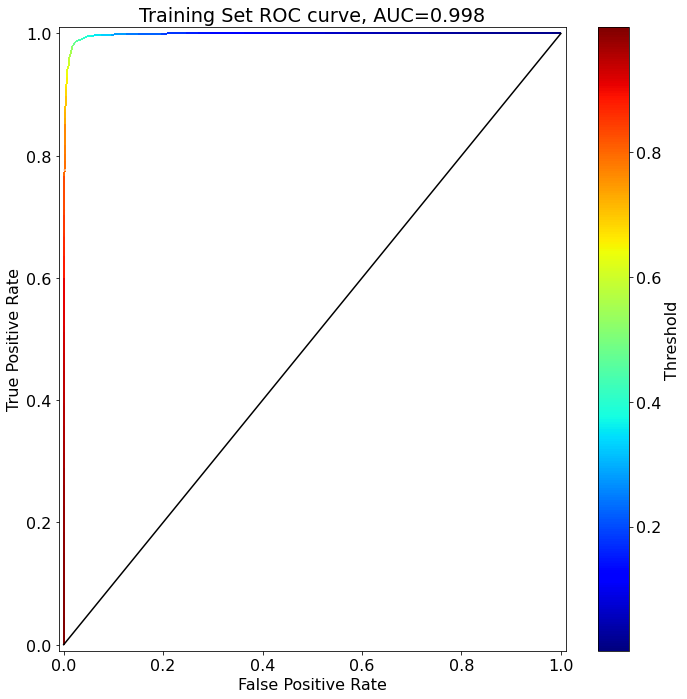

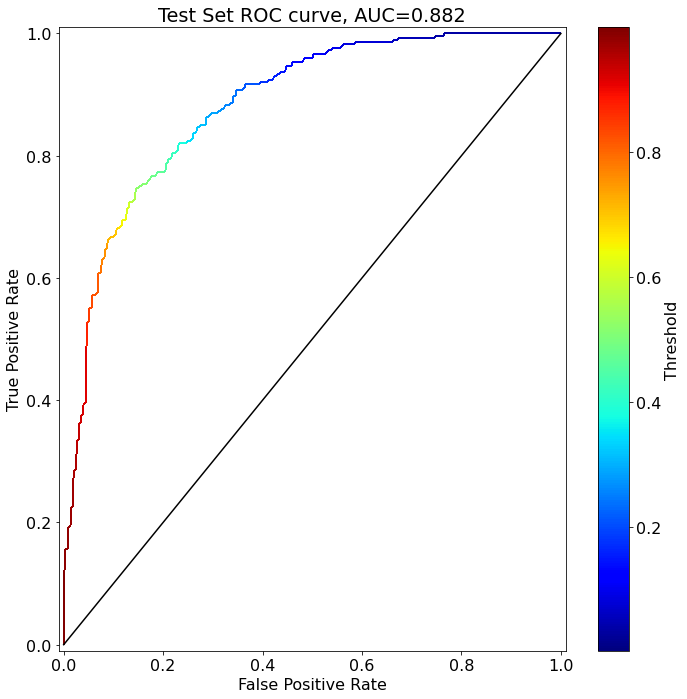

In [23]:
def plot_roc(x, y, label):
        plt.rcParams['figure.figsize'] = [10,10]
        probabilities = best_pipeline.predict_proba(x)[:,1]

        # ROC curve function in sklearn prefers the positive class
        false_positive_rate, true_positive_rate, thresholds = sklearn.metrics.roc_curve(y, probabilities,
                                                                                        pos_label=1)
        thresholds[0] -= 1  # Sklearn arbitrarily adds 1 to the first threshold
        roc_auc = np.round(sklearn.metrics.auc(false_positive_rate, true_positive_rate), 3)

        # Plot the curve
        fig, ax = plt.subplots()
        points = np.array([false_positive_rate, true_positive_rate]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        norm = plt.Normalize(thresholds.min(), thresholds.max())
        lc = matplotlib.collections.LineCollection(segments, cmap='jet', norm=norm, linewidths=2)
        lc.set_array(thresholds)
        line = ax.add_collection(lc)
        fig.colorbar(line, ax=ax).set_label('Threshold')

        # Padding to ensure we see the line
        ax.margins(0.01)

        fig.patch.set_facecolor('white')

        plt.plot([0,1], [0,1], c='k')

        plt.title(f"{label} Set ROC curve, AUC={roc_auc}")

        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.tight_layout()
        plt.savefig(f"{label}_Set_ROC.png")
        plt.show()
        plt.close()


plot_roc(train_x, train_y, "Training")
plot_roc(test_x, test_y, "Test")

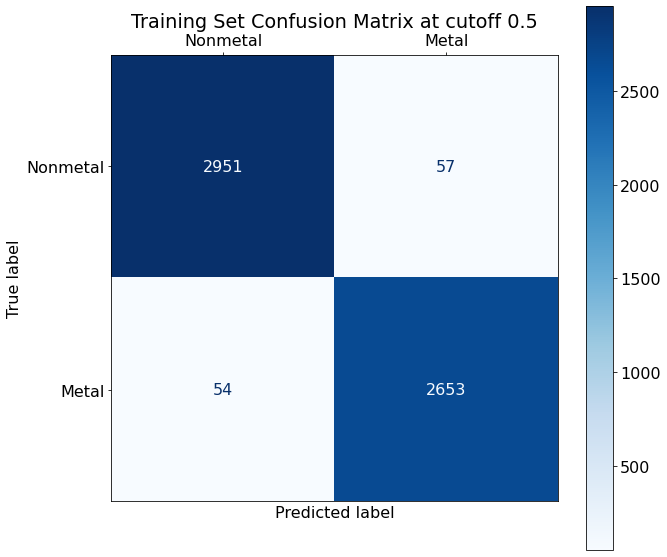

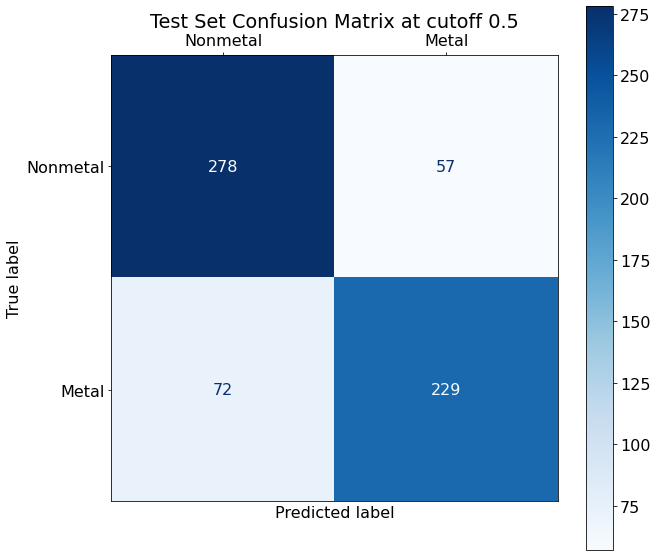

In [24]:
CUTOFF = 0.5

def create_confusion(x,y,label,cutoff=CUTOFF):
    plt.rcParams['figure.facecolor'] = 'white'
    sklearn.metrics.ConfusionMatrixDisplay(
        sklearn.metrics.confusion_matrix(
            y_true=y,
            y_pred=best_pipeline.predict_proba(x)[:,1]>cutoff,
        )
    ).plot(cmap="Blues")
    plt.title(f"{label} Set Confusion Matrix at cutoff {cutoff}")
    plt.xticks([0,1], labels=["Nonmetal", "Metal"])
    plt.yticks([0,1], labels=["Nonmetal", "Metal"])
    plt.gca().xaxis.tick_top()
    plt.savefig(f"{label}_set_confusion_matrix.png")
    plt.show()
    plt.close()

create_confusion(train_x, train_y, "Training")
create_confusion(test_x, test_y, "Test")

In [25]:
train['pred_metal'] = copy.deepcopy(best_pipeline.predict_proba(train_x)[:,1] > CUTOFF)
test['pred_metal'] = copy.deepcopy(best_pipeline.predict_proba(test_x)[:,1] > CUTOFF)


<ipython-input-25-f9049faf401c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['pred_metal'] = copy.deepcopy(best_pipeline.predict_proba(train_x)[:,1] > CUTOFF)
<ipython-input-25-f9049faf401c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_metal'] = copy.deepcopy(best_pipeline.predict_proba(test_x)[:,1] > CUTOFF)


In [26]:
train_metals = train[train['pred_metal'] == True]
train_nonmetals = train[train['pred_metal'] != True]

test_metals = test[test['pred_metal'] == True]
test_nonmetals = test[test['pred_metal'] != True]

In [27]:
xenonpy_descriptors = [col for col in data.columns if ":" in col]
matminer_descriptors = [
    'bond_length_average',
    'bond_angle_average',
    'average_cn',
    'global_instability',
    'perimeter_area_ratio',
    'ewald_energy_per_atom',
    'structural complexity per atom',
    'structural complexity per cell',
    'n_symmetry_ops'

]
xenonpy_matminer_descriptors = xenonpy_descriptors + matminer_descriptors#%%
target = ['bandgap (eV)']


In [28]:
train_x_reg = train_nonmetals[xenonpy_matminer_descriptors].to_numpy()
train_y_reg = train_nonmetals[target].to_numpy()

test_x_reg = test_nonmetals[xenonpy_matminer_descriptors].to_numpy()
test_y_reg = test_nonmetals[target].to_numpy()

Best Pow is 1.6697569756975696 with Tweedie Deviance 0.8371610876427943


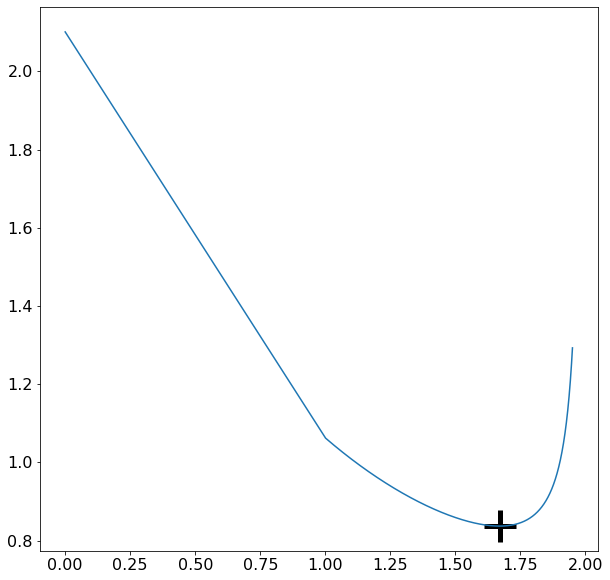

In [29]:
# Find the power that our data falls under in a tweedie distribution
deviances = []

dist = train_nonmetals['bandgap (eV)'].to_numpy()

for tweedie_deviance_power in np.linspace(0,1.95,num=10000):
    try:
        deviances.append([tweedie_deviance_power,
                          sklearn.metrics.mean_tweedie_deviance(y_true=dist,
                                                                y_pred=[abs(dist.mean())]*len(dist),
                                                                power=tweedie_deviance_power)])
    except ValueError:
        pass
plt.plot([i[0] for i in deviances],[i[1] for i in deviances])

best_pow, best_dev = min(deviances, key=lambda i: i[1])
plt.scatter([best_pow], [best_dev], marker="+", c='k', s=1000, lw=5)

print(f"Best Pow is {best_pow} with Tweedie Deviance {best_dev}")

[19:43:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "verboosity" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-tweedie-nloglik@1.66976:7.11831
[1]	validation_0-tweedie-nloglik@1.66976:6.90898
[2]	validation_0-tweedie-nloglik@1.66976:6.72304
[3]	validation_0-tweedie-nloglik@1.66976:6.56352
[4]	validation_0-tweedie-nloglik@1.66976:6.42171
[5]	validation_0-tweedie-nloglik@1.66976:6.29940
[6]	validation_0-tweedie-nloglik@1.66976:6.18984
[7]	validation_0-tweedie-nloglik@1.66976:6.09754
[8]	validation_0-tweedie-nloglik@1.66976:6.02267
[9]	validation_0-tweedie-nloglik@1.66976:5.95499
[10]	validation_0-tweedie-nloglik@1.66976:5.89737
[11]	validation_0-tweedie-nloglik@1.66976:5.85216
[12]	validation_0-tweedie-nloglik@1.66976:5.8105

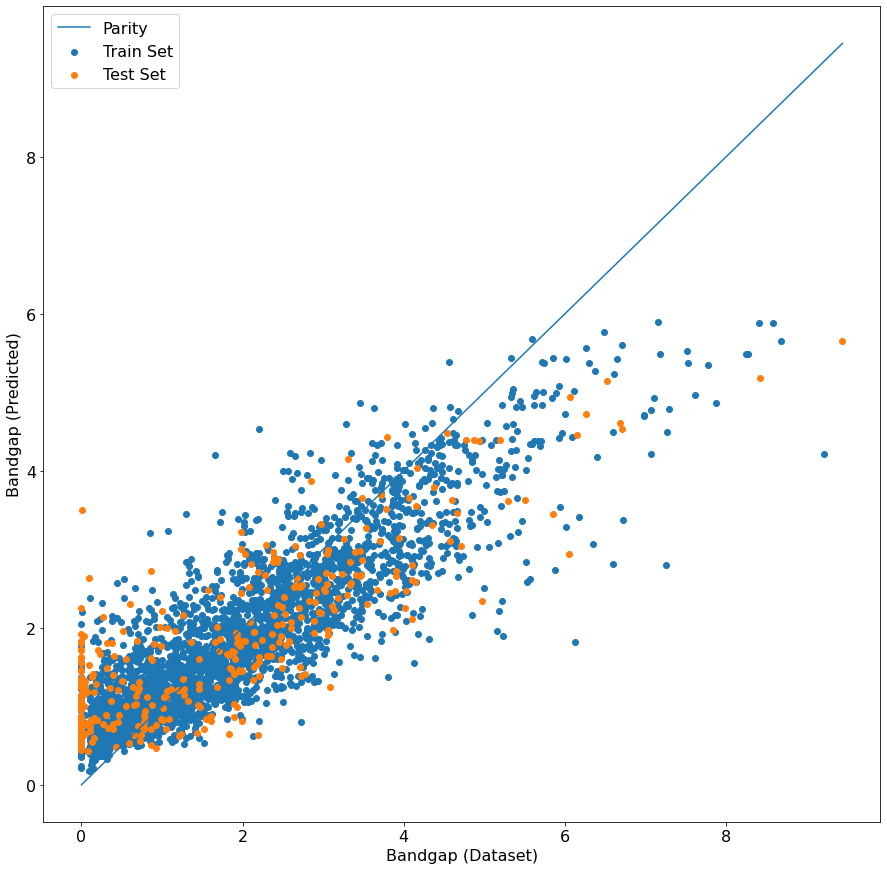

In [30]:
tr_x_reg, val_x_reg, tr_y_reg, val_y_reg = sklearn.model_selection.train_test_split(train_x_reg, train_y_reg, test_size=0.1)
model = xgboost.sklearn.XGBRegressor(
    gamma=5,
    learning_rate=0.1,
    max_depth=32,
    n_estimators=1000,
    subsample=0.5,
    objective='reg:tweedie',
    verboosity=0,
    tweedie_variance_power=best_pow,
    random_state=RANDOM_SEED
)

model.fit(X=tr_x_reg, y=tr_y_reg,
          eval_set=[[val_x_reg, val_y_reg]],
          early_stopping_rounds=10)


y_pred_train = model.predict(train_x_reg)
y_pred_test = model.predict(test_x_reg)

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] = (15, 15)
plt.rcParams["font.size"] = 16

plt.scatter(x=train_y_reg, y=y_pred_train, label="Train Set")
plt.scatter(x=test_y_reg, y=y_pred_test, label="Test Set")

min_xy = min(min(test_y_reg), min(test_y_reg), min(y_pred_test), min(y_pred_train))
max_xy = max(max(test_y_reg), max(test_y_reg), max(y_pred_test), max(y_pred_train))

plt.plot([min_xy, max_xy], [min_xy, max_xy], label="Parity")
plt.ylabel("Bandgap (Predicted)")
plt.xlabel("Bandgap (Dataset)")
plt.legend()
plt.savefig('plot.jpeg')


In [31]:
def rmse(y_true, y_pred):
    mse = sklearn.metrics.mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(abs(mse))
    return rmse

metrics = {
    'MaxError': sklearn.metrics.max_error,
    'MAE': sklearn.metrics.mean_absolute_error,
    'MSE': sklearn.metrics.mean_squared_error,
    'RMSE': rmse,
    'MAPE': sklearn.metrics.mean_absolute_percentage_error,
    'R2': sklearn.metrics.r2_score
}

for key, fun in metrics.items():
    value = fun(y_true=test_y_reg, y_pred=y_pred_test)
    print(key,value)

MaxError 3.797822527313233
MAE 0.7685378297421591
MSE 0.9373106543817362
RMSE 0.9681480539575217
MAPE 723450770219721.5
R2 0.6524910849184049
